# Convolutional Neural Network ( CNN )

<table><tr><td bgcolor=lightyellow>In deep learning, a convolutional neural network (CNN) is a class of deep neural networks, most commonly applied to analyzing visual imagery. We introduce it here with two examples.

## Example 1

<table><tr><td bgcolor=lightyellow>The first example is using CNN to identify images of digits.
<br>Data source:https://www.kaggle.com/dingli/digits-recognition-with-cnn-keras/data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data Preparation

<table><tr><td bgcolor=lightyellow>The images are kept as matrices, each row containing 784 pixels and label of the digit in the first column as shown below. Considering the limit of memory here, we just take part of the whole data.

In [ ]:
train = pd.read_csv("https://quantummc.xyz/wp-content/uploads/2020/07/hku_phys3151_cnn_example1.csv")
train = train[0:4200]
print(train.shape)

In [ ]:
train

<table><tr><td bgcolor=lightyellow>From the training data, we take the labels as Y (result) and the rest as X (input).

In [ ]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)

In [ ]:
Y_train.value_counts()

<table><tr><td bgcolor=lightyellow>As shown above, we count the numbers of different digits, and the result turns out that they have close values.

<table><tr><td bgcolor=lightyellow>To have a view at the relationship between the vectors of pixels and the images, we take the 4th row of the training data as example, we show the image and use the label as the title, which match well.

In [ ]:
img_eg=np.array(X_train)[3].reshape(28,28)
plt.imshow(img_eg,cmap='gray')
plt.title(np.array(Y_train)[3])
plt.axis("off")
plt.show()

<table><tr><td bgcolor=lightyellow>Next, we set the value of pixels to be within the range of 0 to 1. 

In [ ]:
X_train = X_train / 255.0
#test = test / 255.0

<table><tr><td bgcolor=lightyellow>Since we want the pixels of each image to be matrices and Keras (which we are gonna use to build the CNN) needs an extra dimension in the end which correspond to channels(it's 1 here because the images are gray scaled), we reshape the input.

In [ ]:
X_train = X_train.values.reshape(4200,28,28,1)
#test = test.values.reshape(28000,28,28,1)


<table><tr><td bgcolor=lightyellow>The initial Y are the labels which are 0,1,2.... For identification, we convert them into vectors, and thus for example:<br> 2 becomes [0,0,1,0,0,0,0,0,0,0] <br> 0 becomes [1,0,0,0,0,0,0,0,0,0].

In [ ]:
from keras.utils.np_utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 10)
print(Y_train[0])

<table><tr><td bgcolor=lightyellow>At the last step of data preparation, split the data into train and test sets(here we take only $\frac{1}{10}$ of the data as test sets).

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

### CNN Model

<table><tr><td bgcolor=lightyellow>There are different parts in CNN:
<br>1.$\underline{Convolution\ \ Layer}$: Take a small matrix as the feature(kernel, filter), which can be a n by n matrix. Successively, convolve each part(size determined by feature) of the initial matrix and the feature, and we get a feature map as a result.
<br>To avoid decreasing the size after convolution, we use $\underline{padding}$ here, normally adding 0s to the edges.
<br><br>2.$\underline{Activation\ \ Function}$: we use Relu(Rectified Linear Units) here, whose fomula is simple: $f(x)=max(0,x)$, and thus the negative values are turned into 0 while the positive values remain.
<br><br>3.$\underline{Pooling}$: Pooling can shrink a large image while retaining important information. Here, we use Max Pooling: Usually, the pooling matrix is 2 by 2 size, the maximum value in the 2\*2 size block in the input image is taken as the resulting pixel value.
<br><br>4.$\underline{Fully\ \ Connected\ \ Layers}$: In the fully connected layers below, we flatten the pooled feature maps into vectors. Every value we get in the vectors votes for the result, realized by the activation functions. Here, we also include softmax function, the formula of which is: $P=\frac{e^{x^{T}W_j}}{\sum_ke^{x^TW_k}}$. The result represents the probability of the type of the output.
<br><br>In the CNN built below, Dropout is used, where randomly selected neurons are ignored during the training.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (28,28,1))) 
#kernel size refers to the size of the feature matrix
#filters refer to the number of output filters in the convolution
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))      #strides refer to the factor by which to downscale.
model.add(Dropout(0.25))
#fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))   #the first number in the () of Dense refers to the dimension of the output.

<table><tr><td bgcolor=lightyellow>After the construction of the strcture of CNN, we need to set the optimizer. Here we choose Adam, which is an algorithm for performing a stepwise optimization on stochastic objective functions, and the parameters are the ones mostly used in machine learning.
<br>For the loss, we use categorical_crossentropy:$$CCE = -\frac{1}{N}\sum_{i=0}^N\sum_{j=0}^Jy_{i,j}\cdot log(P_{i,j})$$

In [ ]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [ ]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

<table><tr><td bgcolor=lightyellow>The training process can consist of several epochs, one epoch means one forward pass and one backward pass of all the training examples and batch size means the number of training examples in one forward/backward pass.

In [ ]:
epochs = 10  # for better result increase the epochs
batch_size=200

<table><tr><td bgcolor=lightyellow>Then, we fit the model with both the training set and validation set which evaluates the fit.

In [ ]:
history = model.fit(X_train,Y_train, batch_size = None,epochs = epochs, validation_data = (X_val,Y_val), validation_steps=X_train.shape[0] // batch_size, steps_per_epoch=X_train.shape[0] // batch_size)

<table><tr><td bgcolor=lightyellow>After we trained the model, plot the accuracy and loss versus epochs of both the train and validation(test) set.

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
ax[0,0].plot(history.history['acc'])
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Accuracy')
ax[0,0].set_title('Accuracy of Train')
ax[0,1].plot(history.history['loss'])
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_ylabel('Loss')
ax[0,1].set_title('Loss of Train')
ax[1,0].plot(history.history['val_acc'])
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Accuracy')
ax[1,0].set_title('Accuracy of Validation')
ax[1,1].plot(history.history['val_loss'])
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('Loss')
ax[1,1].set_title('Loss of Validation')

<table><tr><td bgcolor=lightyellow>The accuracy is acceptable to some extent.
<br>For more direct view of the fit, plot the confusion matrix of the test set.

### Model Evaluation

In [ ]:
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) #return the max of the axis
Y_true = np.argmax(Y_val,axis = 1)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

In [ ]:
import seaborn as sns
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,linecolor="gray", fmt= '.1f',ax=ax)#fmt refers to type of the data
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

<table><tr><td bgcolor=lightyellow>Through the confusion matrix, we can see exactly how well the test set are predicted

## Example 2

<font color = darkblue>Inspired by the paper Super-resolving the Ising model with convolutional neural networks(https://arxiv.org/abs/1810.02372), we try to use CNN here to restore the decimated configurations of the Ising model back to the initial size with high accuracy.

<font color = darkblue>For the network, the Y would be the initial configuration. To get the X, we firstly do the decimation(RG process) of the Ising model: divide the 2L * 2L lattice into 2x2 blocks where each block is transformed to a spin with the same state as the majority of spins in the block. If the total sign is zero, we take the sign of the upper left spin to make the procedure deterministic. Therefore, we get the L * L lattice.

<font color = darkblue>Then, we increases the resolution from L × L to 2L × 2L by transforming each up (down) spin to a block of four up (down) spins(fig1.a). And the 2L x 2L lattice would be the X of the network, which has the same shape as the Y do but the configuration is different now. And the aim the the network is try to restore the physical observables(here we use magnetization) of X back to that of the Y.

<font color = darkblue>The core of the network is the convolutional layer. Each convolution layer takes a configuration X as input and applies the transformation 
f (W ∗ x + b), where ∗ denotes the convolution operation, W is the so-called filter, b is a bias vector. This function is known as an activation function and the typical choice is the rectified linear function ReLU(x) = max(0, x). The effect of each convolution is to combine local features within a nf × nf region (filter size). A consequence of this is that each convolution layer reduces the images size by eliminating the rightmost and bottom edges. To avoid truncating the image edge, we surround the original configurations with additional spins from the periodic boundary conditions, which is showed in fig 1.

![jupyter](./fig1.png)

In [1]:
import numpy as np
import pandas as pd
import copy
import csv

### Data Preparation

<font color = darkblue>We got initial data from Monte Carlo, and they are 200 configurations of 16 by 16 matrices for each T of totally 61 different Ts.

In [2]:
csvFile = open("cnn_example2.csv")
reader = csv.reader(csvFile)
rows= [row for row in reader]
cdata=np.array(rows)
data_allT=np.zeros((61,np.array(rows[0]).size))
for i in range(0,61):
    data_allT[i]=cdata[2*i]             # because there are blank rows in the file

<font color = darkblue>first of all, we calculate the magnetization of initial lattice

In [3]:
real_M_16_list=[]
realt_list=[]
for temp in range(0,61):
    realt_list.append(1+temp*0.05)
    data_here16=data_allT[temp]
    data_tocalc=copy.deepcopy(data_here16).reshape(200,256)
    m_16=0
    for kk in range(0,200):
        m_16=m_16+abs(np.sum(data_tocalc[kk])/256)
    real_M_16_list.append(m_16/200)

### Network Preparation

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D,Activation,Reshape,Lambda
from keras.optimizers import RMSprop,Adam
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


<font color = darkblue>First, we define a periodic-boundary-condition layer.

In [5]:
def pbc_layer(x,pad=1):
    from keras.backend import tile
    L=x.shape[1]
    y=tile(x,[1,2,2,1])
    return y[:,:L+pad,:L+pad]

In [6]:
import keras.backend as K
from keras.losses import mean_squared_error

<font color = darkblue>As this is a physics problem, we should also consider the loss of physical observables(magnetization and energy of the ising model here) when calculating the total loss.

In [7]:
# calculate M
def calculate_magnetization(state):
    return K.expand_dims(K.mean(state, axis=(1, 2, 3)))
#calculate E
def calculate_energy2D(state, n_spins):
    Ex = K.sum(state[:,:,1:] * state[:,:,:-1], axis=(1, 2))
    Ey = K.sum(state[:,1:] * state[:,:-1], axis=(1, 2))
    Ex+= K.sum(state[:,:,0] * state[:,:,-1], axis=1)
    Ey+= K.sum(state[:,0,:] * state[:,-1,:], axis=1)
    return -(Ex + Ey)[:, 0] / n_spins
def cross_entropy_loss(y_true, y_pred, eps=0.0000001):
    cross_entropy = y_true * K.log(y_pred + eps) + (1.0 -y_true) * K.log(1.0 - y_pred + eps)
    return - K.mean(cross_entropy, axis=(1,2,3))
def regularization(y_true, y_pred, mag_reg, en_reg, n_spins=0):
    y_true = 2 * y_true - 1
    y_pred = 2 * y_pred - 1
    loss = 0
    if mag_reg != 0.0:
        mag_dif = K.square(calculate_magnetization(y_true) - calculate_magnetization(y_pred))
        loss = loss + mag_reg * mag_dif
    if en_reg != 0.0:
        en_dif  = K.square(calculate_energy2D(y_true, n_spins=n_spins) - calculate_energy2D(y_pred, n_spins=n_spins))
        loss = loss + en_reg * en_dif
    return loss
def create_basic_loss(y_true, y_pred, ce=True):
    if ce:
        return cross_entropy_loss(y_true, y_pred)
    else:
        return K.mean(mean_squared_error(y_true, y_pred), axis=(1,2))
def create_loss(y_true, y_pred, ce=True, mag_reg=0.27, en_reg=0.25, n_spins=256):
    loss = create_basic_loss(y_true, y_pred, ce=ce)
    if mag_reg == 0.0 and en_reg == 0.0:
        return loss
    return loss + regularization(y_true, y_pred, mag_reg=mag_reg, en_reg=en_reg,n_spins=n_spins)

<font color = darkblue>Actually, we use one network for configurations at one specific T. So we define a function of the network sturcture. Every time we add a convolutional layer, we add pbc_layer before it to avoid the loss of shape

In [8]:
def thismodel():
    model2 = Sequential()
    model2.add(Lambda(pbc_layer,arguments={'pad':5}))
    model2.add(Conv2D(64,6,padding = 'valid',kernel_initializer='he_normal',activation ='relu'))
    model2.add(Lambda(pbc_layer,arguments={'pad':0}))
    model2.add(Conv2D(32,1,padding = 'valid',kernel_initializer='he_normal',activation ='relu'))
    model2.add(Lambda(pbc_layer,arguments={'pad':2}))
    model2.add(Conv2D(1,3,padding = 'valid',kernel_initializer='glorot_normal',activation ='sigmoid'))
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    model2.compile(optimizer = optimizer , loss = create_loss, metrics=['accuracy'])  
    return model2

In [9]:
from sklearn.model_selection import train_test_split

<font color = darkblue>In the data preparation section, we know that there are 61 Ts in total. For simple display, we just pick a list of indices of Ts. Then, we set the Y and the X after decimation and increasing the resolution. After training, we use the network at each T to do prediction and compare the physical observables obtained from the predicted configuration and initial configuration. we simply write a loop to complte this.

<font color = darkblue>first we set the T_list(just indices)

In [10]:
T_list=[0,5,10,15,20,25,30,35,40,45,50,55,60]

<font color = darkblue>then, start the main loop

In [11]:
# create list for physical measurements

M_predict_16=[]
M_predict_16_error=[]

In [12]:
for eacht in T_list:
    data_separate=copy.deepcopy(data_allT[eacht]).reshape(200,256) # configuration at a specific T
    Y_train=copy.deepcopy(data_separate)       # set the Y
    
    # for configuration, we use -1 and 1 at each site, but we have to change -1 into 0 for the use of network
    
    for i in range(0,len(Y_train)):
        for j in range(0,256):
            if Y_train[i,j]==-1:
                Y_train[i,j]=0
            else:
                Y_train[i,j]=1
    Y_train=Y_train.reshape(-1,16,16,1)          # reshape the tensor for the use of network
    
    # do the decimation
    
    data_dec=np.zeros((200,64))                 # 16x16->8x8
    data_T=copy.deepcopy(data_separate)
    for i in range(0,200):
        ini=data_T[i]
        for ii in range(0,8):
            for iii in range(0,8):
                x=2*ii+32*iii
                sum=ini[x]+ini[x+1]+ini[x+16]+ini[x+17]
                if sum >= 0:
                    data_dec[i,ii+iii*8]=1
                else:
                    data_dec[i,ii+iii*8]=-1
    
    # increases the resolution from 8 × 8 to 16 × 16 by transforming each up (down) spin to a block of four up (down) spins
    
    data_return=np.zeros((200,256))
    for i in range(0,200):
        for ii in range(0,8):
            for iii in range(0,8):
                x=2*ii+32*iii
                this=data_dec[i,ii+iii*8]
                data_return[i,x]=this
                data_return[i,x+1]=this
                data_return[i,x+16]=this
                data_return[i,x+17]=this
    #set X
    
    X_train=copy.deepcopy(data_return).reshape(-1,16,16,1)
    
    # initialize model
    
    this_model=thismodel()
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=42)
    epochs=10
    batch_size = 20
    
    # fit the model
    this_model.fit(X_train,Y_train, batch_size = None,epochs = epochs, validation_data = (X_val,Y_val), validation_steps=X_train.shape[0] // batch_size, steps_per_epoch=X_train.shape[0] // batch_size)
    
    #do prediction
    
    pre=this_model.predict(data_return.reshape(-1,16,16,1))
    pre_re=copy.deepcopy(pre.reshape(-1,256))
    
    for ii in range(0,len(pre_re)):     #change 0 back into -1
        for j in range(0,256):
            pre_re[ii,j]=pre_re[ii,j]*2-1 
    
    # calculate M form predicted configuration
    
    forT2=pre_re
    M22=[]
    for jj in range(0,200):
        M22.append(abs(np.sum(forT2[jj])/256))
    M_predict_16.append(np.mean(M22))
    M_predict_16_error.append(np.std(M22)/np.sqrt(200))
    print(eacht,'done')
    
    

W1103 12:07:18.848133 19344 deprecation_wrapper.py:119] From c:\工具\python\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1103 12:07:18.885032 19344 deprecation_wrapper.py:119] From c:\工具\python\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1103 12:07:18.888025 19344 deprecation_wrapper.py:119] From c:\工具\python\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1103 12:07:18.907974 19344 deprecation_wrapper.py:119] From c:\工具\python\lib\site-packages\keras\backend\tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1103 12:07:18.989267 19344 deprecation_wrapper.py:119] From c:\工具\python\lib\site-packages\keras\backend\tensorflow_

Train on 180 samples, validate on 20 samples
Epoch 1/10
9/9 [==============================] - 2s 265ms/step - loss: 1.3359 - acc: 0.6665 - val_loss: 0.1273 - val_acc: 0.9998
Epoch 2/10
9/9 [==============================] - 2s 214ms/step - loss: 0.0400 - acc: 0.9996 - val_loss: 0.0063 - val_acc: 0.9998
Epoch 3/10
9/9 [==============================] - 2s 213ms/step - loss: 0.0051 - acc: 0.9996 - val_loss: 0.0027 - val_acc: 0.9998
Epoch 4/10
9/9 [==============================] - 2s 214ms/step - loss: 0.0036 - acc: 0.9996 - val_loss: 0.0022 - val_acc: 0.9998
Epoch 5/10
9/9 [==============================] - 2s 213ms/step - loss: 0.0034 - acc: 0.9996 - val_loss: 0.0020 - val_acc: 0.9998
Epoch 6/10
9/9 [==============================] - 2s 214ms/step - loss: 0.0033 - acc: 0.9996 - val_loss: 0.0020 - val_acc: 0.9998
Epoch 7/10
9/9 [==============================] - 2s 213ms/step - loss: 0.0033 - acc: 0.9996 - val_loss: 0.0020 - val_acc: 0.9998
Epoch 8/10
9/9 [=============================

9/9 [==============================] - 3s 324ms/step - loss: 0.9669 - acc: 0.5414 - val_loss: 0.8406 - val_acc: 0.6359
Epoch 2/10
9/9 [==============================] - 2s 227ms/step - loss: 0.7611 - acc: 0.6478 - val_loss: 0.6828 - val_acc: 0.6959
Epoch 3/10
9/9 [==============================] - 2s 227ms/step - loss: 0.6780 - acc: 0.6854 - val_loss: 0.5957 - val_acc: 0.7381
Epoch 4/10
9/9 [==============================] - 2s 227ms/step - loss: 0.5982 - acc: 0.7342 - val_loss: 0.5427 - val_acc: 0.7689
Epoch 5/10
9/9 [==============================] - 2s 228ms/step - loss: 0.5439 - acc: 0.7618 - val_loss: 0.5072 - val_acc: 0.7799
Epoch 6/10
9/9 [==============================] - 2s 228ms/step - loss: 0.5090 - acc: 0.7816 - val_loss: 0.4795 - val_acc: 0.7953
Epoch 7/10
9/9 [==============================] - 2s 228ms/step - loss: 0.4800 - acc: 0.7987 - val_loss: 0.4547 - val_acc: 0.8092
Epoch 8/10
9/9 [==============================] - 2s 228ms/step - loss: 0.4597 - acc: 0.8130 - val_lo

9/9 [==============================] - 3s 382ms/step - loss: 0.8292 - acc: 0.5035 - val_loss: 0.7754 - val_acc: 0.5447
Epoch 2/10
9/9 [==============================] - 2s 231ms/step - loss: 0.7567 - acc: 0.5621 - val_loss: 0.7152 - val_acc: 0.6109
Epoch 3/10
9/9 [==============================] - 2s 231ms/step - loss: 0.7088 - acc: 0.6094 - val_loss: 0.6729 - val_acc: 0.6447
Epoch 4/10
9/9 [==============================] - 2s 232ms/step - loss: 0.6696 - acc: 0.6405 - val_loss: 0.6385 - val_acc: 0.6811
Epoch 5/10
9/9 [==============================] - 2s 232ms/step - loss: 0.6353 - acc: 0.6766 - val_loss: 0.6117 - val_acc: 0.7006
Epoch 6/10
9/9 [==============================] - 2s 235ms/step - loss: 0.6070 - acc: 0.7032 - val_loss: 0.5907 - val_acc: 0.7170
Epoch 7/10
9/9 [==============================] - 2s 234ms/step - loss: 0.5850 - acc: 0.7217 - val_loss: 0.5757 - val_acc: 0.7318
Epoch 8/10
9/9 [==============================] - 2s 232ms/step - loss: 0.5689 - acc: 0.7351 - val_lo

<font color = darkblue>As the T_list is of indices, we have to change it into a list of Ts

In [13]:
predict_tlist=[]
for i in T_list:
    predict_tlist.append(1+i*0.05)

<font color = darkblue>draw the errorbar to compare the result

Text(0, 0.5, 'M')

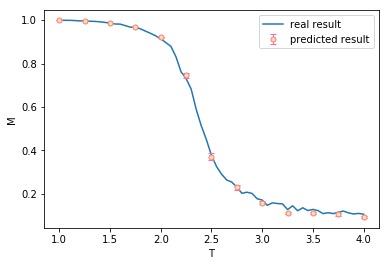

In [16]:
import matplotlib.pyplot as plt
plt.plot(realt_list,real_M_16_list,label='real result')
plt.errorbar(predict_tlist,M_predict_16,yerr=M_predict_16_error,fmt='o',ecolor='hotpink',elinewidth=1,ms=5,mfc='wheat',mec='salmon',capsize=3,label='predicted result')
plt.legend()
plt.xlabel('T')
plt.ylabel('M')

<font color = darkblue>As shown in the figure above, the neural network work well.